#IMPORT LIBS

In [76]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

#Download Data

In [77]:
train_data = datasets.MNIST(root = './data',train=True,download=True,transform=None)
test_data = datasets.MNIST(root = './data',train=False,download=True,transform=None)

#split data

In [78]:
RATIO = 0.9
len_traindata = len(train_data)*0.9
len_validdata = len(train_data) - len_traindata
len_traindata,len_validdata

(54000.0, 6000.0)

In [79]:
train_data,valid_data = data.random_split(train_data,[int(len_traindata),int(len_validdata)])

#Normalize data

In [80]:
mean = train_data.dataset.data.float().mean()/255
std = train_data.dataset.data.float().std()/255
mean,std

(tensor(0.1307), tensor(0.3081))

In [81]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std,inplace=False)
])

In [82]:
train_data.dataset.transform = train_transform
valid_data.dataset.transform = train_transform

In [83]:
train_data

In [84]:
batch_size = 256

In [85]:
train_loader = data.DataLoader(train_data,batch_size=batch_size,shuffle=True)

In [86]:
valid_loader = data.DataLoader(valid_data,batch_size=batch_size,shuffle=True)

#CREATE VGG16 Model

In [90]:
block1 = nn.Sequential(
    nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3,padding='same'),
    nn.ReLU(inplace=True),
    nn.Conv2d(64,64,3,'same'),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2,stride=2)
)


block2 = nn.Sequential(
    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding='same'),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,padding='same'),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2,stride=2)
)


block3 = nn.Sequential(
    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding='same'),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding='same'),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding='same'),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2,stride=2)
)


block4 = nn.Sequential(
    nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding='same'),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding='same'),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding='same'),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2,stride=2)
)


block5 = nn.Sequential(
    nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding='same'),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding='same'),
    nn.ReLU(inplace=True),
    nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding='same'),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2,2)

)

classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512*7*7,4096),nn.ReLU(inplace=True),
    nn.Linear(4096,4096),nn.ReLU(inplace=True),
    nn.Linear(4096,1000),nn.ReLU(inplace=True),
    nn.Linear(1000,10)
)

class vgg16(nn.Module):
  def __init__(self):
    super(vgg16,self).__init__()
    self.block1 = block1
    self.block2 = block2
    self.block3 = block3
    self.block4 = block4
    self.block5 = block5
    self.classifer = classifier
  def forward(self,x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.block5(x)
    x = self.classifier(x)
    return x

In [ ]:
class myLaNet(nn.Module):
  def __init__(self,num_classes):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,padding='same')
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5)
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    self.flatten = nn.Flatten()
    self.layer1 = nn.Linear(16*5*5,120)
    self.layer2 = nn.Linear(120,84)
    self.layer3 = nn.Linear(84,num_classes)

  def forward(self,x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = F.relu(x)

    x = self.conv2(x)
    x = self.pool2(x)
    x = F.relu(x)

    x = self.flatten(x)
    x = (self.layer1(x))
    x = (self.layer2(x))
    x = self.layer3(x)

    return x

#Create train function and evaluation function

In [ ]:
def train(model,criterion,optimizer,device,train_loader,valid_loader,epoch):
  model.train()
  cnt_acc = 0
  cnt_total = 0
  losses = []

  for idx,(inputs,outputs) in enumerate(train_loader):
    inputs = inputs.to(device)
    outputs = outputs.to(device)
    optimizer.zero_grad()
    predict = model(inputs)
    loss = criterion(predict,outputs)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    cnt_acc += (predict.argmax(1) == outputs).sum().item()
    cnt_total += outputs.size(0)
    #if idx % 50 == 0:
      #print(
       # f"epoch {epoch} | accuracy {cnt_acc/cnt_total}"
        #)
     # cnt_acc,cnt_total=0,0
  epoch_acc = cnt_acc/cnt_total
  epoch_loss = sum(losses)/len(losses)
  return epoch_acc,epoch_loss

In [ ]:
#Evaluation function
def evaluation(model,criterion,valid_dataloader,device):
  model.eval()
  total_acc,total_count = 0,0
  losses = []

  with torch.no_grad():
    for idx,(inputs,labels) in enumerate(valid_dataloader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      predictions = model(inputs)
      loss = criterion(predictions,labels)
      losses.append(loss.item())

      total_acc += ( predictions.argmax(1) == labels ).sum().item()
      total_count += labels.size(0)

  epoch_acc = total_acc/total_count
  epoch_loss = sum(losses)/len(losses)
  return epoch_acc,epoch_loss

In [ ]:
#Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = myLaNet(10)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

num_epochs = 10
train_accs ,train_losses = [],[]
eval_accs, eval_losses = [],[]
for epoch in range (1,num_epochs):
  train_acc,train_loss = train(model,criterion,optimizer,device,train_loader,valid_loader,epoch)
  train_accs.append(train_acc)
  train_losses.append(train_loss)

  eval_acc,eval_loss = evaluation(model,criterion,valid_loader,device)
  eval_accs.append(eval_acc)
  eval_losses.append(eval_loss)


epoch 1 | accuracy 0.078125
epoch 1 | accuracy 0.7215625
epoch 1 | accuracy 0.91484375
epoch 1 | accuracy 0.939921875
epoch 1 | accuracy 0.956640625
epoch 2 | accuracy 0.953125
epoch 2 | accuracy 0.969140625
epoch 2 | accuracy 0.96703125
epoch 2 | accuracy 0.974140625
epoch 2 | accuracy 0.9753125
epoch 3 | accuracy 0.9765625
epoch 3 | accuracy 0.98015625
epoch 3 | accuracy 0.977890625
epoch 3 | accuracy 0.981796875
epoch 3 | accuracy 0.98
epoch 4 | accuracy 0.984375
epoch 4 | accuracy 0.983984375
epoch 4 | accuracy 0.984453125
epoch 4 | accuracy 0.985546875
epoch 4 | accuracy 0.98171875
epoch 5 | accuracy 0.9921875
epoch 5 | accuracy 0.985859375
epoch 5 | accuracy 0.98734375
epoch 5 | accuracy 0.985546875
epoch 5 | accuracy 0.985390625
epoch 6 | accuracy 0.99609375
epoch 6 | accuracy 0.990625
epoch 6 | accuracy 0.989140625
epoch 6 | accuracy 0.986953125
epoch 6 | accuracy 0.987109375
epoch 7 | accuracy 0.98046875
epoch 7 | accuracy 0.990390625
epoch 7 | accuracy 0.98984375
epoch 7 | ac

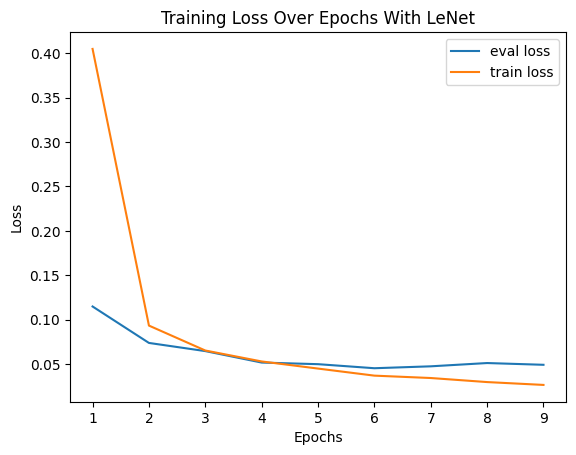

In [68]:
epochs = list(range(1, len(train_losses) + 1))
plt.plot(epochs, eval_losses,label='eval loss')
plt.plot(epochs,train_losses,label='train loss')
plt.title('Training Loss Over Epochs With LeNet')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [89]:
#Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = myLaNet(10)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

num_epochs = 10
train_accs ,train_losses = [],[]
eval_accs, eval_losses = [],[]
for epoch in range (1,num_epochs):
  train_acc,train_loss = train(model,criterion,optimizer,device,train_loader,valid_loader,epoch)
  train_accs.append(train_acc)
  train_losses.append(train_loss)

  eval_acc,eval_loss = evaluation(model,criterion,valid_loader,device)
  eval_accs.append(eval_acc)
  eval_losses.append(eval_loss)


epoch 1 | accuracy 0.0546875


KeyboardInterrupt: ignored